# The Cat's Meow
**An Unsupervised Learning Approach to classifying cat sounds**

I'm convinced my cat thinks I'm a complete ignoramus because I haven't learned a lick of "cat" in our 10 years together. It's not a difficult language. The grammar is straightforward; the vocabulary is limited. Let's see if we can use Unsupervised Machine Learning to help learn more about the types of things cats say. 

![cat-shouting-through-megaphone-blue-backgroundgenerative-ai](https://static.wixstatic.com/media/080994_44699c84709444fdad664c1d431384d0~mv2.jpg/v1/fill/w_815,h_635,al_c,q_85,usm_0.66_1.00_0.01,enc_avif,quality_auto/cat-shouting-through-megaphone-blue-backgroundgenerative-ai%20(1).jpg)

This notebook uses the [Cat Meow Classification](https://www.kaggle.com/datasets/andrewmvd/cat-meow-classification) dataset on Kaggle, which includes 440 audio recordings of cat meows in three contexts: brushing, waiting for food, and isolation in an unfamiliar environment. These contexts can help us evaluate the performance of unsupervised algorithms in grouping recordings based on context.

The dataset follows a naming convention `C_NNNNN_BB_SS_OOOOO_RXX`, where:
- `C` = emission context (values: `B` = brushing; `F` = waiting for food; `I`: isolation in an unfamiliar environment);
- `NNNNN` = cat’s unique ID;
- `BB` = breed (values: `MC` = Maine Coon; `EU`: European Shorthair);
- `SS` = sex (values: `FI` = female, intact; `FN`: female, neutered; `MI`: male, intact; `MN`: male, neutered);
- `OOOOO` = cat owner’s unique ID;
- `R` = recording session (values: `1`, `2` or `3`)
- `XX` = vocalization counter (values: `01..99`)

*A notebook by Erik Anderson (eran6750@colorado.edu) for DTSA 5510 Unsupervised Algorithms in Machine Learning. Find the public repo on GitHub at https://github.com/eriktuck/the-cats-meow*.

In [2]:
from collections import defaultdict
import os

import IPython.display as ipd
from IPython.display import Audio
import kagglehub
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Read data

In [ ]:
# Read dataset (you must have a Kaggle API token)
path = kagglehub.dataset_download("andrewmvd/cat-meow-classification")

# If error, confirm data_dir is set correctly based on your OS
data_dir = os.path.join(path, 'dataset', 'dataset')

# Read audio files
audio_files = os.listdir(data_dir)
audio_files[0]

'B_ANI01_MC_FN_SIM01_101.wav'

: 

: 

In [ ]:
# Extract data to DataFrame
context = {
    'B': 'Brushing', 
    'F': 'Waiting for food', 
    'I': 'Isolation in unfamiliar environment'
}
breed = {
    'MC': 'Maine Coon',
    'EU': 'European Shorthair'
}
sex = {
    'FI': 'Female intact',
    'FN': 'Female neutered',
    'MI': 'Male intact',
    'MN': 'Male neutered'
}

data = []
for a in audio_files:
    metadata = a.split("_")
    metadata[-1] = metadata[-1].split(".")[0]
    metadata.append(a)
    data.append(metadata)

df = pd.DataFrame(data, columns=['context_code', 'cat_id', 'breed_code', 'sex_code', 'owner_id', 'session', 'path'])
df = df.assign(
    context = df['context_code'].map(context),
    breed = df['breed_code'].map(breed),
    sex = df['sex_code'].map(sex)
)

df.head()

,context_code,cat_id,breed_code,sex_code,owner_id,session,path,context,breed,sex
0,B,ANI01,MC,FN,SIM01,101,B_ANI01_MC_FN_SIM01_101.wav,Brushing,Maine Coon,Female neutered
1,B,ANI01,MC,FN,SIM01,102,B_ANI01_MC_FN_SIM01_102.wav,Brushing,Maine Coon,Female neutered
2,B,ANI01,MC,FN,SIM01,103,B_ANI01_MC_FN_SIM01_103.wav,Brushing,Maine Coon,Female neutered
3,B,ANI01,MC,FN,SIM01,301,B_ANI01_MC_FN_SIM01_301.wav,Brushing,Maine Coon,Female neutered
4,B,ANI01,MC,FN,SIM01,302,B_ANI01_MC_FN_SIM01_302.wav,Brushing,Maine Coon,Female neutered


: 

: 

## Exploratory Data Analysis
Although I don't plan to use the metadata for each audio file in the machine learning algorithm, it makes sense to first explore the balance of classes for context, breed and sex to see where these meows are coming from.

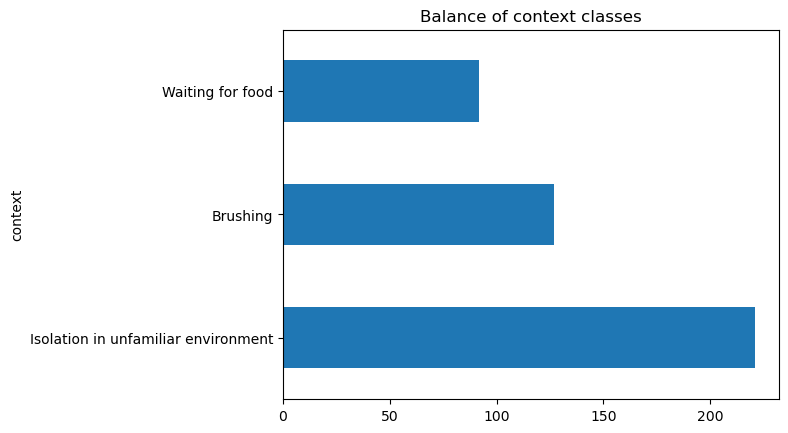

: 

: 

In [ ]:
df['context'].value_counts().plot(kind='barh')
plt.title("Balance of context classes");

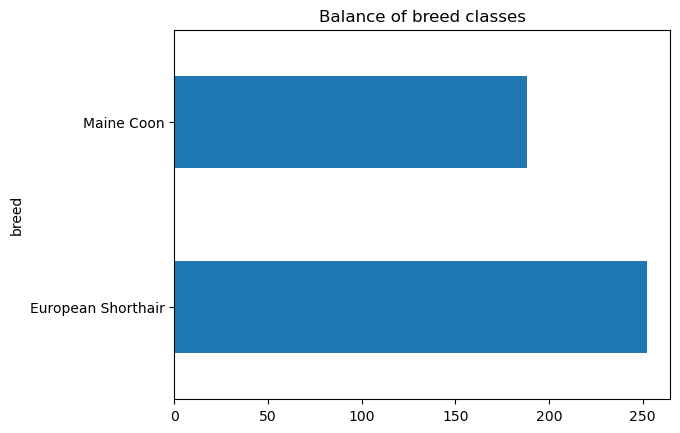

: 

: 

In [ ]:
df['breed'].value_counts().plot(kind='barh')
plt.title("Balance of breed classes");

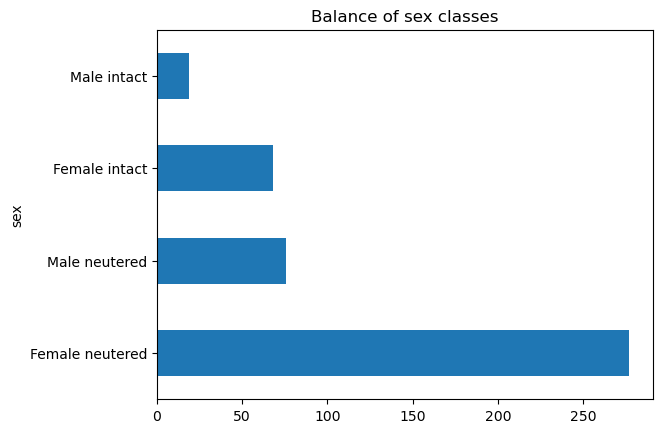

: 

: 

In [ ]:
df['sex'].value_counts().plot(kind='barh')
plt.title("Balance of sex classes");

Now let's look at the audio data itself.

In [ ]:
def plot_waveform(data, sample_rate, title=None):
    time = librosa.times_like(data, sr=sample_rate)
    data, _ = librosa.effects.trim(data)
    plt.figure(figsize=(12, 6))
    plt.plot(time, data, label="Waveform")
    plt.title(title)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

: 

: 

In [ ]:
brushing_example = df[df['context_code']=='B'].iloc[0]['path']
file_path = os.path.join(data_dir, brushing_example)
data, sample_rate = librosa.load(file_path)
librosa.load(file_path)
print("Example meow in brushing context")
ipd.Audio(file_path)

Example meow in brushing context


: 

: 

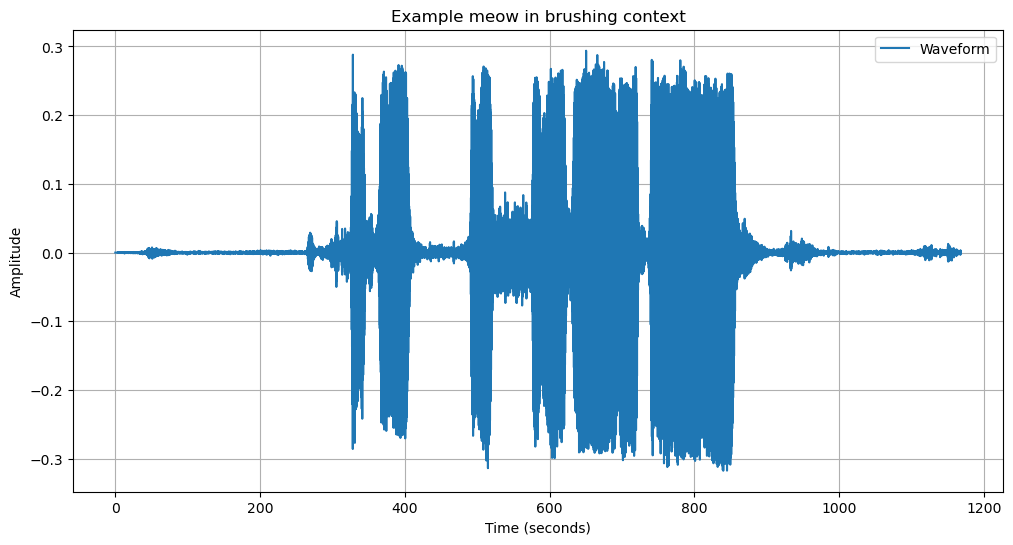

: 

: 

In [ ]:
plot_waveform(data, sample_rate, "Example meow in brushing context")

In [ ]:
feeding_example = df[df['context_code']=='F'].iloc[0]['path']
file_path = os.path.join(data_dir, feeding_example)
data, sample_rate = librosa.load(file_path)
librosa.load(file_path)
print("Example meow in feeding context")
ipd.Audio(file_path)

Example meow in feeding context


: 

: 

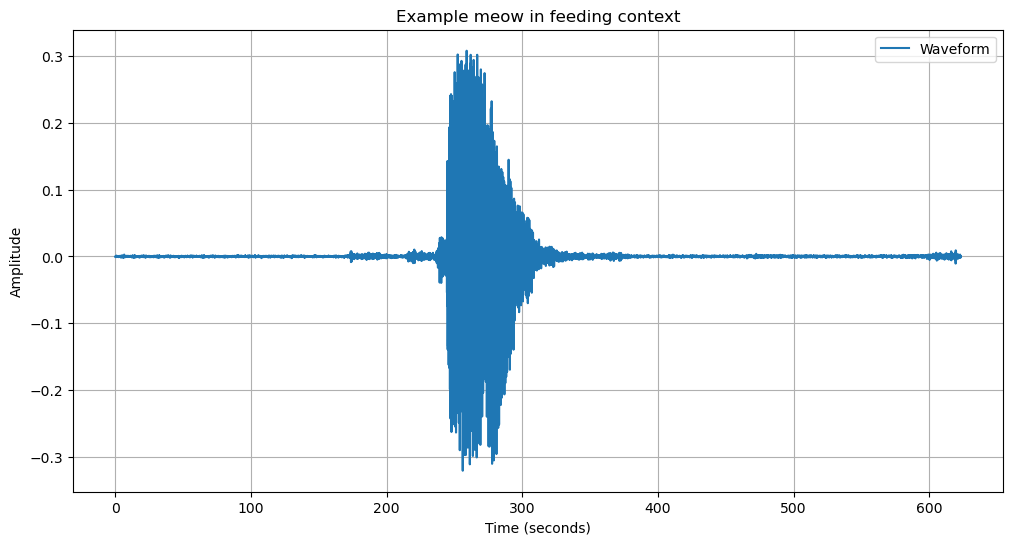

: 

: 

In [ ]:
plot_waveform(data, sample_rate, "Example meow in feeding context")

In [ ]:
isolation_example = df[df['context_code']=='I'].iloc[0]['path']
file_path = os.path.join(data_dir, isolation_example)
data, sample_rate = librosa.load(file_path)
librosa.load(file_path)
print("Example meow in isolation context")
ipd.Audio(file_path)

Example meow in isolation context


: 

: 

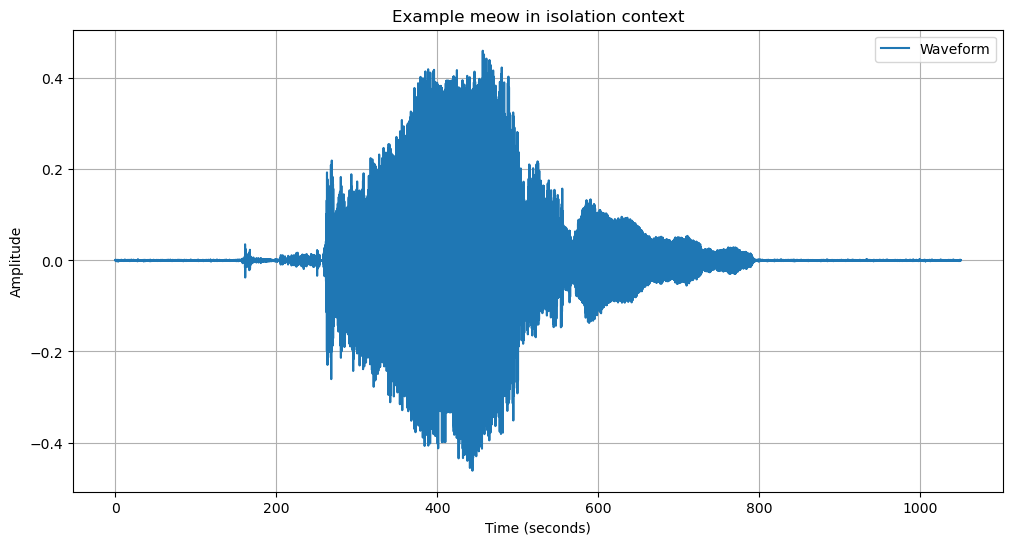

: 

: 

In [ ]:
plot_waveform(data, sample_rate, "Example meow in isolation context")

## Data Preparation
I need to clean the audio files to make them as standard as possible, including trimming silence from the beginning and end, resampling to a shared sample rate, and normalizing the data. 

In [ ]:
def load_and_clean_data(file_path, target_sample_rate=22050):
    data, sample_rate = librosa.load(file_path, sr=None)

    # Trim silence
    data, _ = librosa.effects.trim(data)

    # Resample to target sample rate
    if sample_rate != target_sample_rate:
        data = librosa.resample(data, 
                                orig_sr=sample_rate, 
                                target_sr=target_sample_rate)
        sample_rate = target_sample_rate

    # Normalize audio
    data = librosa.util.normalize(data)

    return data, sample_rate


: 

: 

## Feature Extraction

Librosa offers a [feature module](https://librosa.org/doc/latest/feature.html#feature) to extract features with which we can train an unsupervised classification model. There are a number of options for features that represent audio characterstics, including
- MFCCs (Mel Frequency Cepstral Coefficients): Capture the timbral aspects of the sound.
- Chroma Features: Represent the distribution of energy across the 12 pitch classes.
- Spectral Contrast: Highlights the difference in energy between spectral peaks and valleys.
- Zero Crossing Rate: Measures the rate at which the signal changes sign.
- Spectral Centroid & Roll-off: Provide insights into the “brightness” of the sound.

Because audio data can be thought of as timeseries data (the data is captured over time), summary statistics like mean and variance can be calculated across the time axis to return a single value for each feature for each record.

In [ ]:
def extract_features(data, sample_rate):
    # MFCCs
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Chroma feature
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=data, sr=sample_rate)
    spec_contrast_mean = np.mean(spec_contrast, axis=1)
    
    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(data)
    zcr_mean = np.mean(zcr)
    
    # Spectral Centroid & Roll-off
    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate))
    
    # Concatenate all features into a single vector
    features = np.concatenate([mfccs_mean, chroma_mean, spec_contrast_mean, [zcr_mean, centroid, rolloff]])
    
    return features

: 

: 

In [ ]:
feeding_example = df[df['context_code']=='F'].iloc[0]['path']
file_path = os.path.join(data_dir, feeding_example)

data, sample_rate = load_and_clean_data(file_path)
features = extract_features(data, sample_rate)
features.shape

(35,)

: 

: 

Note I have 35 features now for each audio file. I'll process all files in preparation for developing a model.

In [ ]:
feature_matrix = []
for file in df['path']:
    file_path = os.path.join(data_dir, file)
    data, sample_rate = load_and_clean_data(file_path)
    features = extract_features(data, sample_rate)
    feature_matrix.append(features)

feature_matrix = np.array(feature_matrix)
feature_matrix.shape

(440, 35)

: 

: 

In the final pre-processing / feature extraction step, I'll scale all features using the `sk-learn` `StandardScaler`.

In [ ]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

: 

: 

## Dimensionality Reduction
Next, I'll use PCA to reduce the features down so that we can visually inspect for separation before moving on to clustering algorithms.

In [ ]:
# Dimensionality Reduction (optional, e.g., PCA to 2 components for visualization)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)


: 

: 

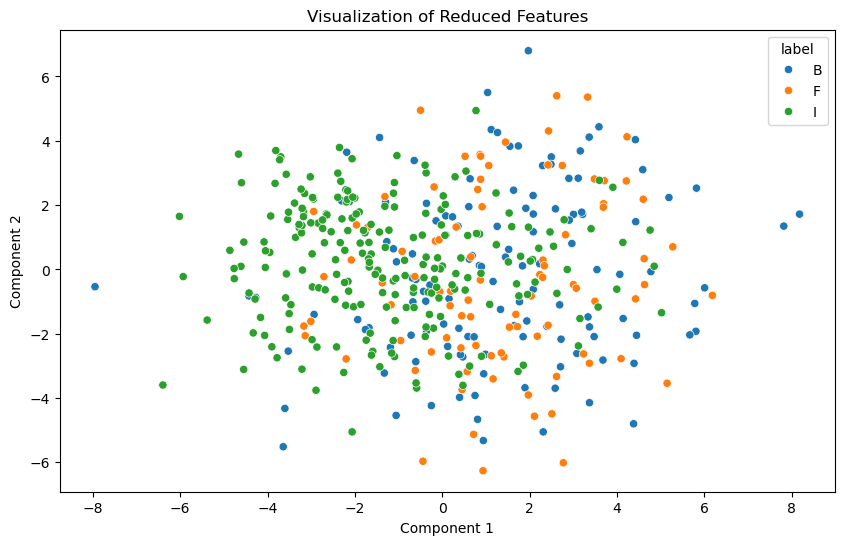

: 

: 

In [ ]:
df_vis = pd.DataFrame(reduced_features, columns=['Component 1', 'Component 2'])
df_vis['label'] = df['context_code']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_vis, x='Component 1', y='Component 2', hue='label')
plt.title("Visualization of Reduced Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

We can see from this chart that there is some, but not much, seperation between "meows" in each of the three contexts. While I am not specifically attempting to predict the context based on the sound--which would be considered a supervised learning problem--the context can be used as a proxy for evaluating accuracy of the model if I assume that cats "say" different things in different contexts. 

From the strictly unsupervised perspective, however, the single large cluster represented here also indicates that there may not be any natural clusters in the dataset to discover. 

## K-Means Clustering
A simple unsupervised learning algorithm is K-means clustering, implemented in `sklearn` as `KMeans`. This algorithm attempts to discover clusters based on the number of means, a hyperparameter. 

c:\Users\erikt\miniforge3\envs\meow\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


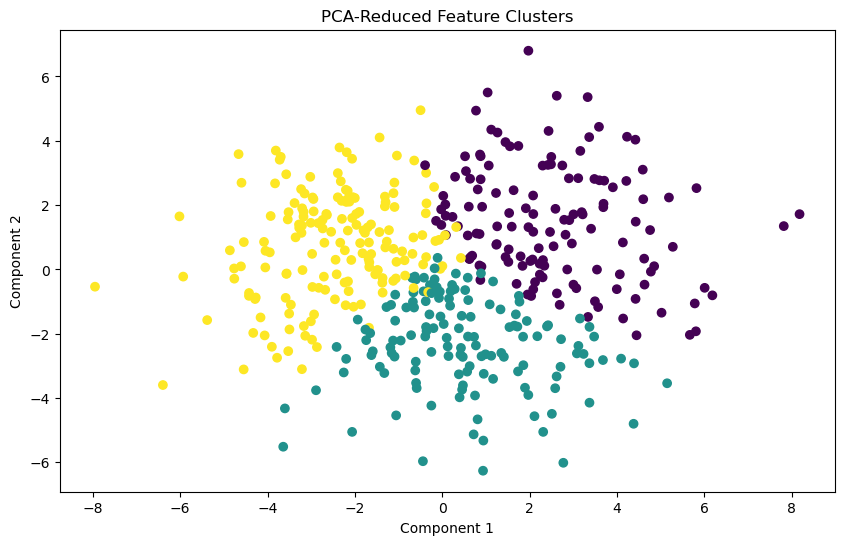

: 

: 

In [ ]:
# KMeans cluster with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
k_clusters = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=k_clusters, cmap='viridis')
plt.title("PCA-Reduced Feature Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

I will evaluate the performance of the algorithm by comparing the cluster label with attributes of the cat that issued the meow using a Chi-squared contingency table.

In [ ]:
# Create contingency tables for each categorical variable vs. clusters.
ct_context = pd.crosstab(df['context'], k_clusters)
ct_breed   = pd.crosstab(df['breed'], k_clusters)
ct_sex     = pd.crosstab(df['sex'], k_clusters)

# Chi-square tests for independence
chi2_context, p_context, dof_context, _ = stats.chi2_contingency(ct_context)
chi2_breed,   p_breed,   dof_breed,   _ = stats.chi2_contingency(ct_breed)
chi2_sex,     p_sex,     dof_sex,     _ = stats.chi2_contingency(ct_sex)

print("Context vs Cluster: Chi2 =", chi2_context, "p =", p_context)
print("Breed vs Cluster:   Chi2 =", chi2_breed,   "p =", p_breed)
print("Sex vs Cluster:     Chi2 =", chi2_sex,     "p =", p_sex)

Context vs Cluster: Chi2 = 97.92688684905623 p = 2.717058990569351e-20
Breed vs Cluster:   Chi2 = 4.007356047965023 p = 0.13483843109634439
Sex vs Cluster:     Chi2 = 25.85305058923685 p = 0.00023712121992803354


: 

: 

There appears to be a statistically significant association between the clusters predicted and the cat's context (brushing, feeding or isolated) and sex (male/female plus intact/neutered). That suggests that our algorithm is keying in on differences in the sounds that can be correlated with context and sex. However, this doesn't necessarily mean that our clusters are doing a good job of predicting those values, for that we should look at prediction accuracy.

In [ ]:
def clustering_accuracy(y_true, y_pred):
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get the unique labels
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    
    # Create a cost matrix where cost[i, j] is the negative number of samples with true label i and pred label j.
    cost_matrix = np.zeros((len(true_labels), len(pred_labels)), dtype=int)
    for i, true_label in enumerate(true_labels):
        for j, pred_label in enumerate(pred_labels):
            matches = np.sum((y_true == true_label) & (y_pred == pred_label))
            cost_matrix[i, j] = -matches  # we take negative because linear_sum_assignment minimizes cost
    
    # Solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_correct = -cost_matrix[row_ind, col_ind].sum()
    
    # Accuracy is the fraction of total correct predictions
    accuracy = total_correct / y_true.size
    return accuracy

: 

: 

In [ ]:
acc = clustering_accuracy(df['context'], k_clusters)
print(f"Clustering accuracy for predicting context: {acc:.1%}")
acc = clustering_accuracy(df['sex'], k_clusters)
print(f"Clustering accuracy for predicting sex: {acc:.1%}")

Clustering accuracy for predicting context: 52.5%
Clustering accuracy for predicting sex: 36.4%


: 

: 

In [ ]:
df['sex'].value_counts().div(df.shape[0])

sex
Female neutered    0.629545
Male neutered      0.172727
Female intact      0.154545
Male intact        0.043182
Name: count, dtype: float64

: 

: 

The accuracy for predicting context is 52.5%, which is approximately equal to the naive assignment which is to assign all labels the most frequent class, in this case 221 / 440 = 50%. However for sex the naive assignment would be to the most common class "Female neutered" for 277/440 or 63% accuracy and 36% is less.

If I combine both sex and context into a single variable, we can see that the algorithm is teasing apart meaningful differences in cat sex and context when labeling each meow.

In [ ]:
acc = clustering_accuracy(df['sex_code'] + df['context_code'], k_clusters)
print(f"Clustering accuracy for predicting sex/context combination: {acc:.1%}")

Clustering accuracy for predicting sex/context combination: 36.1%


: 

: 

However, we should be careful because we've created a new classification that could be imbalanced.

<Axes: >

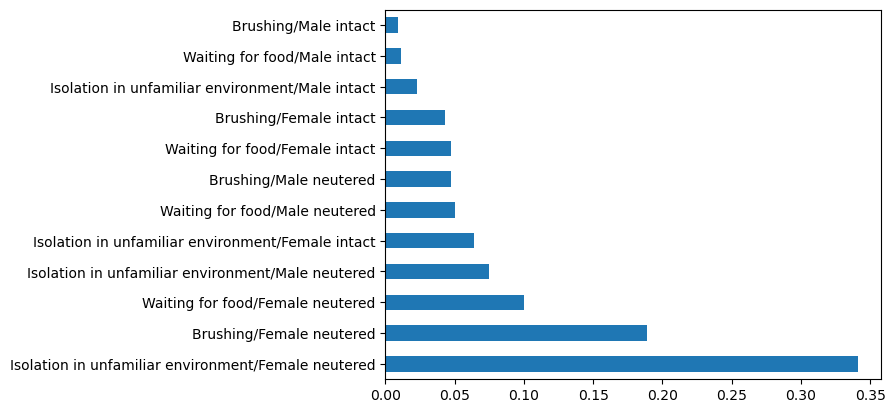

: 

: 

In [ ]:
((df['context'] + "/" + df['sex']).value_counts() / 440).plot(kind='barh')

In fact, the naive assignment would be to the Isolation/Female neutered class for accuracy of 34%, similar to what I achieved.

Finally, I'll inspect a confusion matrix for the context as compared to the class label to see how these overlap.

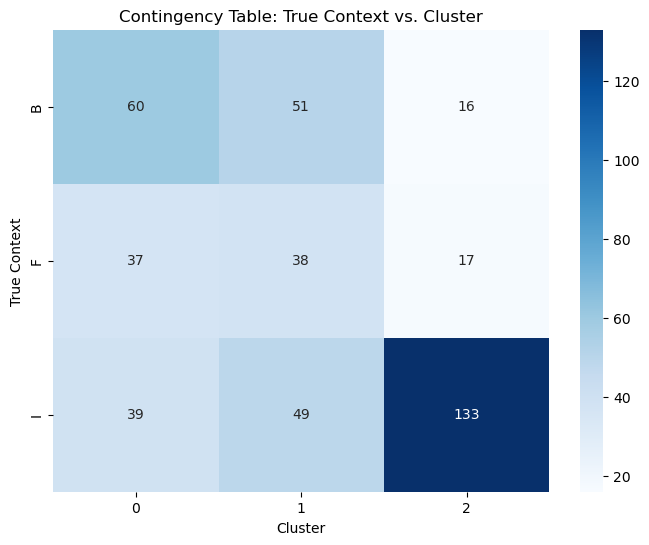

: 

: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Use a crosstab (contingency table) to compare true context codes to cluster labels
cm_df = pd.crosstab(df['context_code'], k_clusters.astype(str))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Cluster")
plt.ylabel("True Context")
plt.title("Contingency Table: True Context vs. Cluster")
plt.show()


Again, it's important to recognize that we are not necessarily attempting to predict the cat's context based on the audio sample, but this confusion matrix does reveal that there is very little actual agreement between any cluster label and any context, with the exception that cluster label `2` seems to be disproportionally associated with the context "Isolated in an unfamiliar environment".

### Hyperparameter tuning for KMeans
The only hyperparameter for KMeans is `k`. I'll iterate through a range of values to compare accuracies for the sex and context combination.

In [ ]:
for i in range(3, 13):
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    acc = clustering_accuracy(df['context_code'] + df['sex_code'], clusters)
    print(f"Clustering accuracy for predicting context (k={i}): {acc:.1%}")

Clustering accuracy for predicting context (k=3): 36.1%
Clustering accuracy for predicting context (k=4): 37.7%
Clustering accuracy for predicting context (k=5): 33.9%
Clustering accuracy for predicting context (k=6): 33.9%
Clustering accuracy for predicting context (k=7): 35.5%
Clustering accuracy for predicting context (k=8): 29.5%
Clustering accuracy for predicting context (k=9): 32.5%
Clustering accuracy for predicting context (k=10): 29.5%
Clustering accuracy for predicting context (k=11): 28.6%
Clustering accuracy for predicting context (k=12): 27.7%


c:\Users\erikt\miniforge3\envs\meow\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erikt\miniforge3\envs\meow\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erikt\miniforge3\envs\meow\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erikt\miniforge3\envs\meow\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMe

: 

: 

The maximum accuracy observed is 38% with `k=4`.

## Hierarchical Clustering
Hierarchical clustering is an alternative clustering algorithm with additional hyperparameters that may be tuned to increase aggreement between the cluster label and cat characteristics. I'll use the F1 score to compare accuracy to attempt a balance between type I and type II errors and avoid selecting models that assing naively to the dominant class.

In [ ]:
def f1_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Identify unique labels in the true and predicted arrays.
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    
    # Create a cost matrix where each entry is the negative count of matching samples.
    cost_matrix = np.zeros((len(true_labels), len(pred_labels)), dtype=int)
    for i, t in enumerate(true_labels):
        for j, p in enumerate(pred_labels):
            cost_matrix[i, j] = -np.sum((y_true == t) & (y_pred == p))
    
    # Use the Hungarian algorithm to find the best mapping.
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Build a mapping from each predicted label to a true label.
    mapping = {}
    for i, j in zip(row_ind, col_ind):
        mapping[pred_labels[j]] = true_labels[i]
    
    # Map the predicted cluster labels to the corresponding true labels.
    mapped_pred = np.array([mapping[p] for p in y_pred])
    
    # Compute the macro F1 score and convert it to a percentage.
    f1 = f1_score(y_true, mapped_pred, average='macro')
    return f1

: 

: 

In [ ]:
# Define the grid of parameters.
linkages = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
n_clusters_list = range(3, 13)

best_acc = 0
best_metric = None
best_n_clusters = None
best_clusters = None

# Grid search over distance metrics and number of clusters.
for linkage in linkages:
    for metric in distance_metrics:
        for n_clusters in n_clusters_list:
            clustering_model = AgglomerativeClustering(
                n_clusters=n_clusters,
                metric=metric if linkage != 'ward' else 'euclidean',
                linkage=linkage
            )
            clusters = clustering_model.fit_predict(scaled_features)
            acc = f1_accuracy(df['context'] + df['sex'], clusters)
            print(f"Distance metric: {metric}, n_clusters: {n_clusters}, Clustering accuracy: {acc:.4f}")
            
            if acc > best_acc:
                best_acc = acc
                best_metric = metric
                best_n_clusters = n_clusters
                best_clusters = clusters

print(f"\nBest result: Linkage: {linkage}, Distance metric: {best_metric}, n_clusters: {best_n_clusters}, accuracy: {best_acc:.4f}")

Distance metric: euclidean, n_clusters: 3, Clustering accuracy: 0.1073
Distance metric: euclidean, n_clusters: 4, Clustering accuracy: 0.1293
Distance metric: euclidean, n_clusters: 5, Clustering accuracy: 0.1440
Distance metric: euclidean, n_clusters: 6, Clustering accuracy: 0.1660
Distance metric: euclidean, n_clusters: 7, Clustering accuracy: 0.1862
Distance metric: euclidean, n_clusters: 8, Clustering accuracy: 0.1875
Distance metric: euclidean, n_clusters: 9, Clustering accuracy: 0.1962
Distance metric: euclidean, n_clusters: 10, Clustering accuracy: 0.2030
Distance metric: euclidean, n_clusters: 11, Clustering accuracy: 0.1966
Distance metric: euclidean, n_clusters: 12, Clustering accuracy: 0.2162
Distance metric: l1, n_clusters: 3, Clustering accuracy: 0.1073
Distance metric: l1, n_clusters: 4, Clustering accuracy: 0.1293
Distance metric: l1, n_clusters: 5, Clustering accuracy: 0.1440
Distance metric: l1, n_clusters: 6, Clustering accuracy: 0.1660
Distance metric: l1, n_clusters

: 

: 

Using hierarchical clustering, I found that the best algorithm for agreement with the combination of cat sex and context uses `linkage=single`, `metric=l1`, and `n_clusters=9`. An F1 score of 25.4% is obtained.

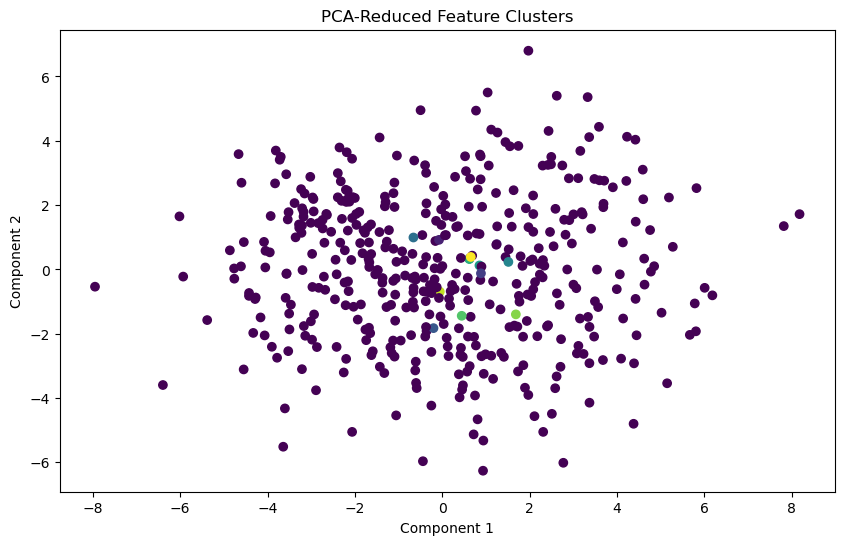

: 

: 

In [ ]:
clustering_model = AgglomerativeClustering(
    n_clusters=12,
    metric='cosine',
    linkage='single'
)
h_clusters = clustering_model.fit_predict(scaled_features)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=h_clusters, cmap='viridis')
plt.title("PCA-Reduced Feature Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

However, we can quickly see that this agreeement has been achieved simply by finding the algorithm that assigns the majority class.

<Axes: >

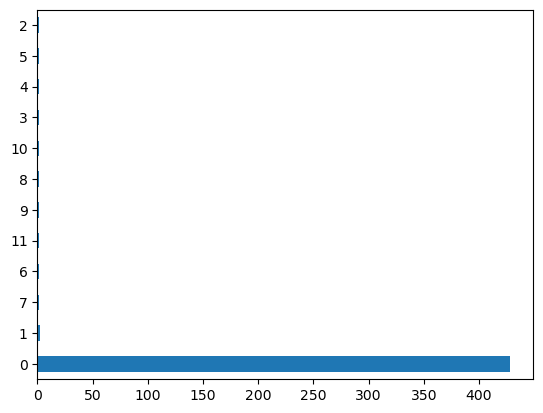

: 

: 

In [ ]:
pd.Series(h_clusters).value_counts().plot(kind='barh')

Thus far, I've explored two algorithms for Unsupervised Machine Learning: K-means clustering and hierarchical clustering. By comparing the intersections of class labels and the context in which the meow was recorded, I've discovered a statistically significant but not particulary predictive relationship between the class labels and meow context. 

That is not to say that the class labels are not informative. It is a big assumption that all meows in the same context should have the same "meaning". The benefit of the unsupervised approach is to discover hidden patterns that might not correspond exactly to the class labels we have in the dataset.

I'll plot the waveforms for meows in each context and the meows in each label, using the K-means clustering algorithm, to help visualize what, if any, characterstics in the waveform might be helpful for teasing apart different types of meows.

In [ ]:
def plot_grouped_waveforms(file_paths, labels, target_sample_rate=22050, alpha=0.3):
    # Group file paths by label
    grouped_files = defaultdict(list)
    for path, label in zip(file_paths, labels):
        grouped_files[label].append(path)
    
    n_groups = len(grouped_files)
    fig, axes = plt.subplots(nrows=1, ncols=n_groups, figsize=(4*n_groups, 4), sharey=True)
    
    # In case there's only one group, axes won't be an array
    if n_groups == 1:
        axes = [axes]
    
    for ax, (label, paths) in zip(axes, sorted(grouped_files.items())):
        all_waveforms = []
        for file in paths:
            data, sr = load_and_clean_data(file, target_sample_rate=target_sample_rate)
            time = librosa.times_like(data, sr=sr)
            ax.plot(time, data, color='gray', alpha=alpha)
            all_waveforms.append(data)
        
        # Compute the average waveform; truncate waveforms to same length
        min_length = min([len(w) for w in all_waveforms])
        truncated = np.array([w[:min_length] for w in all_waveforms])
        avg_waveform = np.mean(truncated, axis=0)
        avg_time = librosa.times_like(avg_waveform, sr=target_sample_rate)
        ax.plot(avg_time, avg_waveform, color='red', linewidth=2, label='Average')
        
        ax.set_title(f"Class {label} (n={len(paths)})")
        ax.set_xlabel("Time (s)")
        ax.grid(True)
        ax.legend()
    
    axes[0].set_ylabel("Amplitude")
    plt.tight_layout()
    plt.show()


: 

: 

C:\Users\erikt\AppData\Local\Temp\ipykernel_14760\2197846284.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


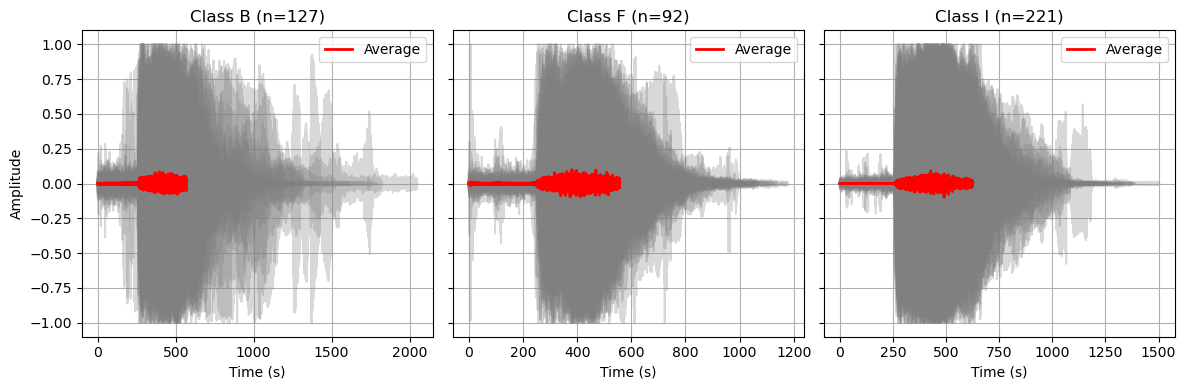

: 

: 

In [ ]:
file_paths = [os.path.join(data_dir, file) for file in df['path']]
labels = df['context_code']
plot_grouped_waveforms(file_paths, labels)

C:\Users\erikt\AppData\Local\Temp\ipykernel_14760\2197846284.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\erikt\miniforge3\envs\meow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


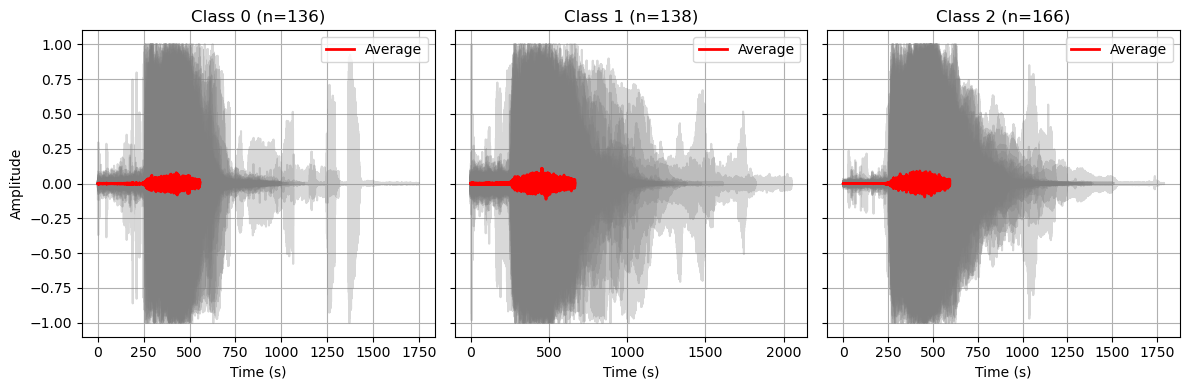

: 

: 

In [ ]:
plot_grouped_waveforms(file_paths, k_clusters.astype(str))

## Supervised Approach: Random Forests
For completeness, I'll train a supervised approach to classifying meows to explictly predict the context based on the data labels.

In [ ]:
X = scaled_features
y = df['context_code']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train context classifier
context_clf = RandomForestClassifier(random_state=42)
context_clf.fit(X_train, y_train)

# Evaluate context classifier
y_pred = context_clf.predict(X_test)
print("Context Classification Report:")
print(classification_report(y_test, y_pred))

Context Classification Report:
              precision    recall  f1-score   support

           B       0.62      0.68      0.65        34
           F       0.70      0.41      0.52        17
           I       0.73      0.81      0.77        37

    accuracy                           0.68        88
   macro avg       0.68      0.63      0.65        88
weighted avg       0.68      0.68      0.67        88



: 

: 

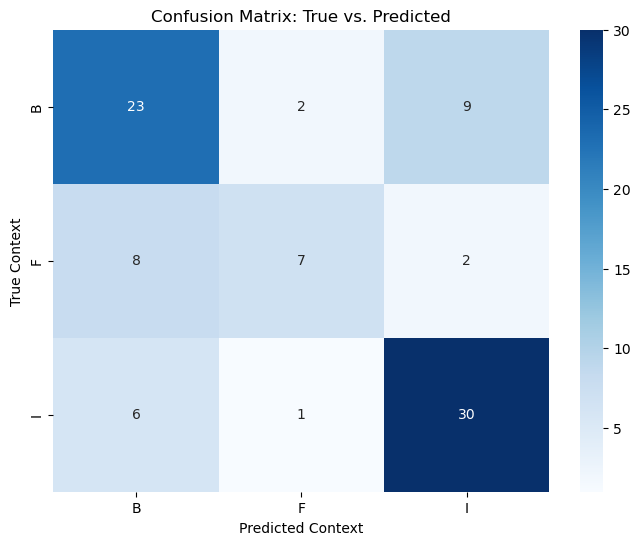

: 

: 

In [ ]:
labels = ['B', 'F', 'I']
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Create a DataFrame for the confusion matrix for easier visualization
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Context")
plt.ylabel("True Context")
plt.title("Confusion Matrix: True vs. Predicted")
plt.show()

The Random Forests classifier does a reasonably good job of predicting the context based on the audio file (test accuracy 68%). 

## Conclusion
With this notebook I attempted to discover natural groupings in audio recordings of cat meows using features including the timbral aspects of the sound, the distribution of energy across the 12 pitch classes, the difference in energy between spectral peaks and valleys, the rate at which the signal changes sign, and insights into the “brightness” of the sound.

The dataset included metadata like the cat's breed, sex and the context in which the meow was recorded. The audio features proved reasonably helpful in predicting the context in which the meow was recorded using a supervised learning algorithm Random Forests. 

The audio features also enabled detection of natural clusters using K0means clustering and Hierarchical clustering, both unsupervised machine learning algorithms. There was only slight agreement between the unsupervised learning algorithm labels and the context in which the meow was recorded, however this was not an explicit objective of the unsupervised machine learning task.

Do I speak "cat" yet? No. But as a cat owner I can assert that cats are using their meows to communicate different things at different times. The supervised approach also provides similar evidence. With additional feature engineering and some domain expertise, it may be possible to translate "cat" into our human languages. In fact, the [Coller-Dollittle Prize](https://coller-dolittle-24.sites.tau.ac.il/) is a half-a-million dollars available to anyone who can!

## Acknowledgements
My appreciation to Kanyaratp29 for supplying the cat-meow-classification dataset (see citation on Kaggle for original dataset attribution).

This notebook benefited from the example notebooks uploaded to Kaggle, including the notebook [CSC287_Cat Sound Classification](https://www.kaggle.com/code/kanyaratp29/csc287-cat-sound-classification) by Kanyaratp29. 

ChatGPT o3-mini-high was used for code debugging and refactoring. The core analysis, structure, and conclusions in this notebook are my own.